# Comparison of Different Taxonomic Classification Approaches

This notebook compares the performance and results of different taxonomic classification methods:

1. **Manual Curation** - Ground truth from expert manual annotation
2. **Palmprint Results** - Palmprint-based classification
3. **DIAMOND** - Traditional BLAST-like sequence alignment tool
4. **MEGAN6** - Metagenome analysis tool
5. **Model Predictions** - Machine learning model predictions

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import os

# Add utils to path
sys.path.append('../scripts')
from utils import *

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

## Data Loading and Preprocessing

Load results from all classification approaches for comparison.

In [2]:
df = pd.read_excel('/home/tobamo/analize/project-tobamo/analysis/data/domain_sci_input/Tobamo - tabela za tobamo kontige - kategorije_2025-09-23.xlsx', header=0, skiprows=[1])

In [3]:
# Define data paths
results_dir = os.makedirs('results/comparison_study', exist_ok=True)

ground_truth = pd.read_excel('/home/tobamo/analize/project-tobamo/analysis/data/domain_sci_input/ground_truth_final_added_categories.xlsx')
diamond_megan_results = pd.read_csv('/home/tobamo/analize/project-tobamo/results/megan6_results_combined_add_nr_taxa.csv')
model_predictions = pd.read_csv('/home/tobamo/analize/project-tobamo/analysis/model/results/snakemake/predictions/contig_predictions.csv')
palmprint = SeqIO.to_dict(SeqIO.parse('/home/tobamo/analize/project-tobamo/analysis/palmprint/results/palmscan/palmscan_pp_find0.fa','fasta'))

## Method 1: Manual Curation (Ground Truth)

Expert manual annotations serving as ground truth for comparison.

### Key Features:
- High accuracy from expert knowledge
- Time-intensive process
- Serves as benchmark for other methods

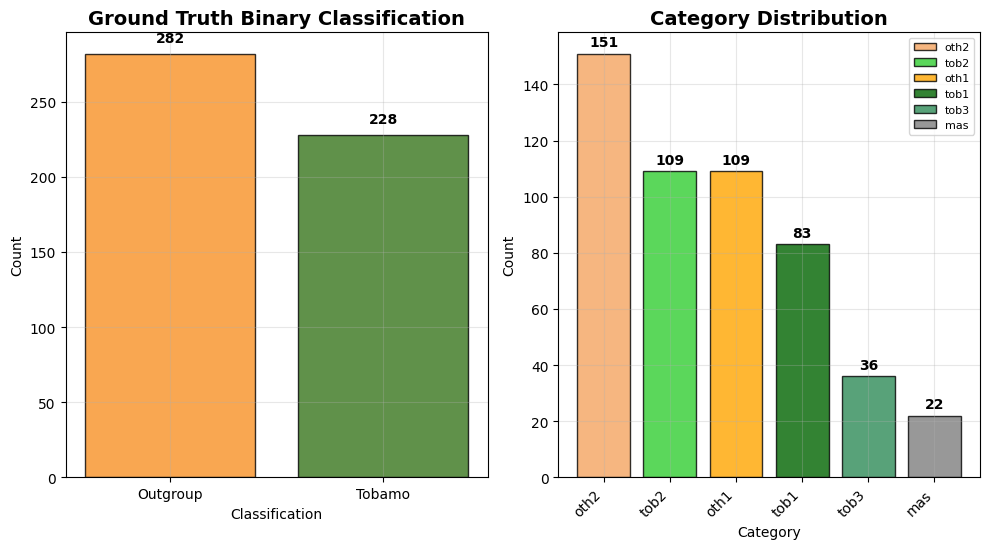

=== GROUND TRUTH DATASET SUMMARY ===
Total samples: 510
Available columns: ['contig_name', 'ground_truth', 'category_old', 'category']

Ground Truth binary classification:
  Outgroup (0): 282 (55.3%)
  Tobamo (1): 228 (44.7%)

Category distribution:
  oth2: 151 (29.6%) - Sequences belonging to other viruses
  tob2: 109 (21.4%) - Tobamoviral sequences - novel
  oth1: 109 (21.4%) - Sequences belonging/related to other members of Virgaviridae
  tob1: 83 (16.3%) - Tobamoviral sequences - known
  tob3: 36 (7.1%) - Tobamoviral sequences - difficult to assign
  mas: 22 (4.3%) - Misassembled sequences


In [4]:
# Ground Truth Distribution Analysis

# Define the category palette
category_palette = {
    'tob1': "#006400",   # dark green
    'tob2': "#32CD32",   # lime green
    'tob3': "#2E8B57",   # sea green
    'oth1': "#FFA500",   # orange
    'oth2': "#F4A460",   # sandy brown
    'oth3': "#cd853f",   # peru
    'mas': "#7f7f7f",   # grey
}

# Define category descriptions
category_map = {
    'tob1': "Tobamoviral sequences - known",
    'tob2': "Tobamoviral sequences - novel",
    'tob3': "Tobamoviral sequences - difficult to assign",
    'oth1': "Sequences belonging/related to other members of Virgaviridae",
    'oth2': "Sequences belonging to other viruses",
    'oth3': "Sequences belonging to other viruses - difficult to assign",
    'mas': "Misassembled sequences"
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.6))

# Plot 1: ground_truth distribution (binary classification)
if 'ground_truth' in ground_truth.columns:
    # Create binary labels
    binary_labels = {0.0: 'Outgroup', 1.0: 'Tobamo'}
    binary_colors = {0.0: '#f89125', 1.0: '#38761d'}  # Red for outgroup, teal for tobamo
    
    ground_truth_counts = ground_truth['ground_truth'].value_counts().sort_index()
    
    # Create bars with custom colors
    bars = []
    for value in ground_truth_counts.index:
        color = binary_colors.get(value, 'gray')
        label = binary_labels.get(value, f'Unknown ({value})')
        bar = ax1.bar(label, ground_truth_counts[value], 
                     color=color, edgecolor='black', alpha=0.8)
        bars.extend(bar)
    
    ax1.set_title('Ground Truth Binary Classification', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Classification')
    ax1.set_ylabel('Count')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (value, count) in enumerate(ground_truth_counts.items()):
        ax1.text(i, count + max(ground_truth_counts.values) * 0.02, str(count), 
                ha='center', va='bottom', fontweight='bold')
else:
    ax1.text(0.5, 0.5, 'ground_truth column\nnot found', 
             ha='center', va='center', transform=ax1.transAxes, 
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
    ax1.set_title('Ground Truth Binary Classification', fontsize=14, fontweight='bold')

# Plot 2: category distribution with custom color palette
if 'category' in ground_truth.columns:
    category_counts = ground_truth['category'].value_counts()
    
    # Create bars with category-specific colors
    colors = [category_palette.get(cat, '#CCCCCC') for cat in category_counts.index]
    
    bars = ax2.bar(range(len(category_counts)), category_counts.values, 
                   color=colors, edgecolor='black', alpha=0.8)
    
    ax2.set_title('Category Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Category')
    ax2.set_ylabel('Count')
    ax2.set_xticks(range(len(category_counts)))
    ax2.set_xticklabels(category_counts.index, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(category_counts.values):
        ax2.text(i, v + max(category_counts.values) * 0.01, str(v), 
                ha='center', va='bottom', fontweight='bold')
        
    # Add legend for categories
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=category_palette.get(cat, '#CCCCCC'), 
                                   edgecolor='black', alpha=0.8, label=f'{cat}')
                      for cat in category_counts.index if cat in category_palette]
    if legend_elements:
        ax2.legend(handles=legend_elements, loc='upper right', fontsize=8)
        
else:
    ax2.text(0.5, 0.5, 'category column\nnot found', 
             ha='center', va='center', transform=ax2.transAxes, 
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
    ax2.set_title('Category Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print("=== GROUND TRUTH DATASET SUMMARY ===")
print(f"Total samples: {len(ground_truth)}")
print(f"Available columns: {list(ground_truth.columns)}")

if 'ground_truth' in ground_truth.columns:
    print(f"\nGround Truth binary classification:")
    for value, count in ground_truth['ground_truth'].value_counts().sort_index().items():
        class_name = 'Outgroup' if value == 0.0 else 'Tobamo' if value == 1.0 else f'Unknown ({value})'
        print(f"  {class_name} ({value}): {count} ({count/len(ground_truth)*100:.1f}%)")

if 'category' in ground_truth.columns:
    print(f"\nCategory distribution:")
    for category, count in ground_truth['category'].value_counts().items():
        description = category_map.get(category, "Unknown category")
        print(f"  {category}: {count} ({count/len(ground_truth)*100:.1f}%) - {description}")

## Method 1: PALMPRINT

In [5]:
palmprint_positive_contigs = ['_'.join(k.split('_')[:-1]) for k in palmprint.keys()]

In [6]:
df['palmprint'] = np.where(df['contig_id'].isin(palmprint_positive_contigs), 1, 0)
tobamo_palmprints = df[(df['palmprint'] == 1) & (df['ground_truth_category'].isin(['tob1','tob2','tob3']))]

print(f"{len(tobamo_palmprints)} actual tobamo out of {df[df['ground_truth_category'].isin(['tob1','tob2','tob3'])].shape[0]} assigned tobamo, which is ({len(tobamo_palmprints) / df[df['ground_truth_category'].isin(['tob1','tob2','tob3'])].shape[0] * 100:.1f}%) total assigned tobamo")

40 actual tobamo out of 228 assigned tobamo, which is (17.5%) total assigned tobamo


## Method 2: DIAMOND Classification

Traditional sequence alignment-based classification using DIAMOND.

### Key Features:
- Fast BLAST-like sequence aligner
- Well-established and widely used
- Provides alignment scores and e-values

In [7]:
nt_tobamo = df[df['first_diamond_blastx_hit_name'].str.contains('tobamovirus', case=False, na=False)]
nt_tobamo_correct = df[(df['first_diamond_blastx_hit_name'].str.contains('tobamovirus', case=False, na=False)) & (df['ground_truth_category'].isin(['tob1','tob2','tob3']))]
print(f"{df[(df['first_diamond_blastx_hit_name'].str.contains('tobamovirus', case=False, na=False)) & (df['ground_truth_category'].isin(['tob1','tob2','tob3']))].shape[0]} actual tobamo out of {df[df['ground_truth_category'].isin(['tob1','tob2','tob3'])].shape[0]} assigned tobamo, which is ({df[(df['first_diamond_blastx_hit_name'].str.contains('tobamovirus', case=False, na=False)) & (df['ground_truth_category'].isin(['tob1','tob2','tob3']))].shape[0] / df[df['ground_truth_category'].isin(['tob1','tob2','tob3'])].shape[0] * 100:.1f}%) total assigned tobamo")

186 actual tobamo out of 228 assigned tobamo, which is (81.6%) total assigned tobamo


## Method 3: MEGAN6 Classification

Metagenome analysis using MEGAN6 for taxonomic assignment.

### Key Features:
- Specialized for metagenome analysis
- Uses LCA (Lowest Common Ancestor) algorithm
- Integrates multiple alignment results

In [8]:
# MEGAN6 results analysis
# Extract MEGAN6 specific results from the combined file

diamond_megan_results.drop_duplicates(subset='qseqid', keep='first')
megan_tax_mapper = diamond_megan_results.set_index('qseqid')['megan_tax'].to_dict()
df['megan_tax'] = df['contig_id'].map(megan_tax_mapper)

megan_tobamo = df[(df['megan_tax'].str.contains('tobamovirus', case=False, na=False))]
megan_tobamo_correct = df[(df['megan_tax'].str.contains('tobamovirus', case=False, na=False)) & (df['ground_truth_category'].isin(['tob1','tob2','tob3']))]
print(f"{megan_tobamo.shape[0]} actual tobamo out of {df['ground_truth_category'].isin(['tob1','tob2','tob3']).sum()} assigned tobamo, which is ({megan_tobamo.shape[0] / df['ground_truth_category'].isin(['tob1','tob2','tob3']).sum() * 100:.1f}%) total assigned tobamo")

215 actual tobamo out of 228 assigned tobamo, which is (94.3%) total assigned tobamo


## Method 4: Machine Learning Model Predictions

Analysis of ML model-based taxonomic predictions.

### Key Features:
- Trained on curated datasets
- Can learn complex patterns in sequence data
- Provides confidence scores for predictions

In [9]:
model_tobamo = df[(df['model_prediction'] == 1) & (df['ground_truth_category'].isin(['tob1','tob2','tob3']))]
print(f"{model_tobamo.shape[0]} actual tobamo out of {df['ground_truth_category'].isin(['tob1','tob2','tob3']).sum()} assigned tobamo, which is ({model_tobamo.shape[0] / df['ground_truth_category'].isin(['tob1','tob2','tob3']).sum() * 100:.1f}%) total assigned tobamo")

212 actual tobamo out of 228 assigned tobamo, which is (93.0%) total assigned tobamo


### COMBINE METHOD

In [10]:
# Create comprehensive ground truth dataset with all method predictions

# Start with a copy of the ground truth dataset
ground_truth_extended = ground_truth.copy()

print("Adding method predictions to ground truth dataset...")

# Try to find a common identifier column
common_id = None
for col in ground_truth.columns:
    if col in df.columns:
        common_id = col
        break

# Create mapping dictionaries for each method
palmprint_mapping = {}
diamond_mapping = {}
megan_mapping = {}
model_mapping = {}

for idx, row in df.iterrows():
    contig_id = row['contig_id']
    palmprint_mapping[contig_id] = 1 if contig_id in palmprint_positive_contigs else 0
    diamond_mapping[contig_id] = 1 if pd.notna(row['first_diamond_blastx_hit_name']) and 'tobamovirus' in str(row['first_diamond_blastx_hit_name']).lower() else 0
    megan_mapping[contig_id] = 1 if pd.notna(row.get('megan_tax', '')) and 'tobamovirus' in str(row.get('megan_tax', '')).lower() else 0
    model_mapping[contig_id] = int(row.get('model_prediction', 0))

# Initialize columns with default values
ground_truth_extended['palmprint'] = 0
ground_truth_extended['diamond_nr'] = 0
ground_truth_extended['megan'] = 0
ground_truth_extended['model'] = 0

# Find identifier column in ground truth
if 'contig_id' in ground_truth.columns:
    identifier_col = 'contig_id'
elif 'id' in ground_truth.columns:
    identifier_col = 'id'
else:
    identifier_col = None
    for col in ground_truth.columns:
        if ground_truth[col].dtype == 'object':
            sample_values = ground_truth[col].dropna().head(3).values
            if any(isinstance(val, str) and ('contig' in val.lower() or '_' in val) for val in sample_values):
                identifier_col = col
                break

if identifier_col:
    matched_count = 0
    for idx, row in ground_truth_extended.iterrows():
        contig_id = row[identifier_col]
        
        if contig_id in palmprint_mapping:
            ground_truth_extended.at[idx, 'palmprint'] = palmprint_mapping[contig_id]
        if contig_id in diamond_mapping:
            ground_truth_extended.at[idx, 'diamond_nr'] = diamond_mapping[contig_id]
        if contig_id in megan_mapping:
            ground_truth_extended.at[idx, 'megan'] = megan_mapping[contig_id]
        if contig_id in model_mapping:
            ground_truth_extended.at[idx, 'model'] = model_mapping[contig_id]
            matched_count += 1
    
    print(f"Matched {matched_count}/{len(ground_truth_extended)} entries using '{identifier_col}' column")
else:
    print("Warning: No identifier column found - predictions remain as defaults")

# Summary statistics
print(f"\nPrediction summary:")
for method in ['palmprint', 'diamond_nr', 'megan', 'model']:
    positive_count = (ground_truth_extended[method] == 1).sum()
    print(f"  {method}: {positive_count} positives ({positive_count/len(ground_truth_extended)*100:.1f}%)")

# Display sample
display_cols = ['ground_truth', 'category', 'palmprint', 'diamond_nr', 'megan', 'model']
available_cols = [col for col in display_cols if col in ground_truth_extended.columns]
print(f"\nSample of extended dataset:")

ground_truth_extended

Adding method predictions to ground truth dataset...
Matched 510/510 entries using 'contig_name' column

Prediction summary:
  palmprint: 146 positives (28.6%)
  diamond_nr: 205 positives (40.2%)
  megan: 215 positives (42.2%)
  model: 285 positives (55.9%)

Sample of extended dataset:


,contig_name,ground_truth,category_old,category,palmprint,diamond_nr,megan,model
0,k119_47794_flag_1_multi_143.0000_len_5109_SRR5...,0,5,oth2,0,0,0,1
1,k141_112743_flag_1_multi_2.0000_len_612_SRR728...,1,1,tob1,0,1,0,1
2,k141_1210_flag_1_multi_2.0000_len_787_SRR1784304,1,2,tob2,0,1,0,1
3,k141_12174_flag_1_multi_7.0000_len_1106_SRR178...,1,2,tob2,0,1,0,1
4,k141_135785_flag_1_multi_5.0000_len_1201_SRR72...,1,1,tob1,0,1,0,1
...,...,...,...,...,...,...,...,...
505,NODE_9562_length_2589_cov_93.538279_SRR769314,0,5,oth2,0,0,0,0
506,NODE_9608_length_2629_cov_6.756270_SRR10143187,0,3,oth1,1,0,0,0
507,NODE_9819_length_675_cov_2.186131_SRR12904122,1,1,tob1,0,1,1,1
508,NODE_9835_length_2717_cov_4.322727_SRR10255703,0,5,oth2,1,0,0,0


# HERE

In [11]:
gt = ground_truth.drop(columns=['category_old'])
gt['palmprint_present'] = np.where(gt['contig_name'].isin(palmprint_positive_contigs), 1, 0)
gt['palmprint_tobamovirus_correct'] = np.where((gt['palmprint_present']) & (gt['ground_truth'] == 1), 1, 0)
gt['palmprint_tobamovirus_false'] = np.where((gt['palmprint_present']) & (gt['ground_truth'] == 1) &(gt['ground_truth'] == 0), 1, 0)
gt['diamond_nr_tobamovirus'] = np.where(gt['contig_name'].isin(nt_tobamo['contig_id']), 1, 0)
gt['diamond_nr_tobamovirus_correct'] = np.where((gt['diamond_nr_tobamovirus']) & (gt['ground_truth'] == 1), 1, 0)
gt['diamond_nr_tobamovirus_false'] = np.where((gt['diamond_nr_tobamovirus']) & (gt['ground_truth'] == 0), 1, 0)
gt['megan_tobamovirus'] = np.where(gt['contig_name'].isin(megan_tobamo['contig_id']), 1, 0)
gt['megan_tobamovirus_correct'] = np.where((gt['megan_tobamovirus']) & (gt['ground_truth'] == 1), 1, 0)
gt['megan_tobamovirus_false'] = np.where((gt['megan_tobamovirus']) & (gt['ground_truth'] == 0), 1, 0)
gt['model_predictions'] = np.where(gt['contig_name'].isin(model_predictions[model_predictions['predicted_class'] == 1]['contig_name']), 1, 0)
gt['model_predictions_correct'] = np.where((gt['model_predictions']) & (gt['ground_truth'] == 1), 1, 0)
gt['model_predictions_false'] = np.where((gt['model_predictions']) & (gt['ground_truth'] == 0), 1, 0)

gt

,contig_name,ground_truth,category,palmprint_present,palmprint_tobamovirus_correct,palmprint_tobamovirus_false,diamond_nr_tobamovirus,diamond_nr_tobamovirus_correct,diamond_nr_tobamovirus_false,megan_tobamovirus,megan_tobamovirus_correct,megan_tobamovirus_false,model_predictions,model_predictions_correct,model_predictions_false
0,k119_47794_flag_1_multi_143.0000_len_5109_SRR5...,0,oth2,0,0,0,0,0,0,0,0,0,1,0,1
1,k141_112743_flag_1_multi_2.0000_len_612_SRR728...,1,tob1,0,0,0,1,1,0,0,0,0,1,1,0
2,k141_1210_flag_1_multi_2.0000_len_787_SRR1784304,1,tob2,0,0,0,1,1,0,0,0,0,1,1,0
3,k141_12174_flag_1_multi_7.0000_len_1106_SRR178...,1,tob2,0,0,0,1,1,0,0,0,0,1,1,0
4,k141_135785_flag_1_multi_5.0000_len_1201_SRR72...,1,tob1,0,0,0,1,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,NODE_9562_length_2589_cov_93.538279_SRR769314,0,oth2,0,0,0,0,0,0,0,0,0,0,0,0
506,NODE_9608_length_2629_cov_6.756270_SRR10143187,0,oth1,1,0,0,0,0,0,0,0,0,0,0,0
507,NODE_9819_length_675_cov_2.186131_SRR12904122,1,tob1,0,0,0,1,1,0,1,1,0,1,1,0
508,NODE_9835_length_2717_cov_4.322727_SRR10255703,0,oth2,1,0,0,0,0,0,0,0,0,0,0,0


correct classifications

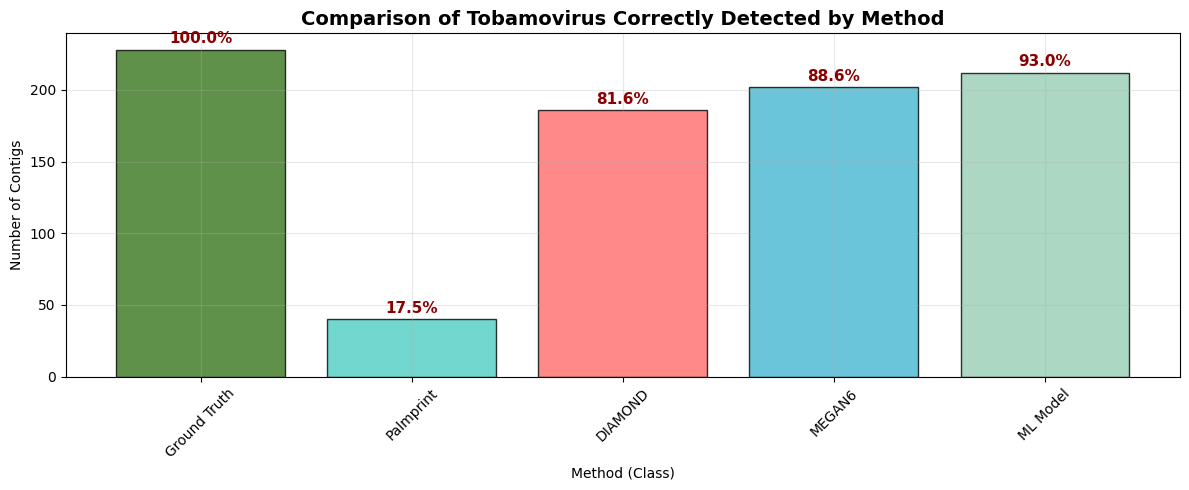

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,5))

columns_to_plot = ['ground_truth', 'palmprint_tobamovirus_correct', 'diamond_nr_tobamovirus_correct', 'megan_tobamovirus_correct', 'model_predictions_correct']
labels = ['Ground Truth', 'Palmprint', 'DIAMOND', 'MEGAN6', 'ML Model']
colors = ['#38761d', '#4ECDC4', '#FF6B6B', '#45B7D1', '#96CEB4']

# Show only positive class (value == 1) for each method
for i, col in enumerate(columns_to_plot):
    if 1 in gt[col].value_counts().index:
        count = gt[col].value_counts().get(1, 0)
        ax.bar(labels[i], count, color=colors[i], alpha=0.8, edgecolor='black')


# Add percentage labels on bars
ground_truth_total = gt['ground_truth'].value_counts().get(1, 0)
for i, col in enumerate(columns_to_plot):
    count = gt[col].value_counts().get(1, 0)
    percentage = (count / ground_truth_total * 100) if ground_truth_total > 0 else 0
    ax.text(i, count + ground_truth_total * 0.01, f'{percentage:.1f}%', 
            ha='center', va='bottom', fontweight='bold', fontsize=11, color='darkred')

ax.set_title('Comparison of Tobamovirus Correctly Detected by Method', fontsize=14, fontweight='bold')
ax.set_xlabel('Method (Class)')
ax.set_ylabel('Number of Contigs')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()


plt.show()

In [20]:
gt

,contig_name,ground_truth,category,palmprint_present,palmprint_tobamovirus_correct,palmprint_tobamovirus_false,diamond_nr_tobamovirus,diamond_nr_tobamovirus_correct,diamond_nr_tobamovirus_false,megan_tobamovirus,megan_tobamovirus_correct,megan_tobamovirus_false,model_predictions,model_predictions_correct,model_predictions_false
0,k119_47794_flag_1_multi_143.0000_len_5109_SRR5...,0,oth2,0,0,0,0,0,0,0,0,0,1,0,1
1,k141_112743_flag_1_multi_2.0000_len_612_SRR728...,1,tob1,0,0,0,1,1,0,0,0,0,1,1,0
2,k141_1210_flag_1_multi_2.0000_len_787_SRR1784304,1,tob2,0,0,0,1,1,0,0,0,0,1,1,0
3,k141_12174_flag_1_multi_7.0000_len_1106_SRR178...,1,tob2,0,0,0,1,1,0,0,0,0,1,1,0
4,k141_135785_flag_1_multi_5.0000_len_1201_SRR72...,1,tob1,0,0,0,1,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,NODE_9562_length_2589_cov_93.538279_SRR769314,0,oth2,0,0,0,0,0,0,0,0,0,0,0,0
506,NODE_9608_length_2629_cov_6.756270_SRR10143187,0,oth1,1,0,0,0,0,0,0,0,0,0,0,0
507,NODE_9819_length_675_cov_2.186131_SRR12904122,1,tob1,0,0,0,1,1,0,1,1,0,1,1,0
508,NODE_9835_length_2717_cov_4.322727_SRR10255703,0,oth2,1,0,0,0,0,0,0,0,0,0,0,0


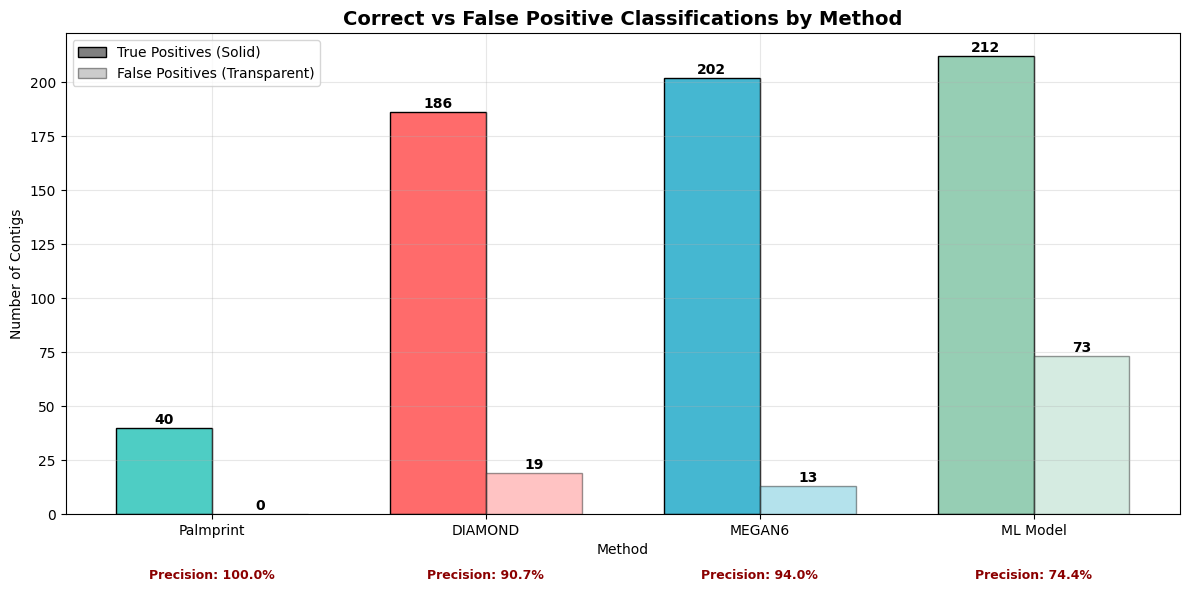

In [19]:
# Plot correct and false positives for each method

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(12, 6))

# Define methods and their corresponding columns
methods = ['Palmprint', 'DIAMOND', 'MEGAN6', 'ML Model']
correct_cols = ['palmprint_tobamovirus_correct', 'diamond_nr_tobamovirus_correct', 'megan_tobamovirus_correct', 'model_predictions_correct']
false_cols = ['palmprint_tobamovirus_false', 'diamond_nr_tobamovirus_false', 'megan_tobamovirus_false', 'model_predictions_false']

# Colors for correct and false positives
colors_correct = ['#4ECDC4', '#FF6B6B', '#45B7D1', '#96CEB4']
colors_false = ['#FF7F7F', '#FFB6B6', '#87CEEB', '#C6E6C7']

# Calculate counts
correct_counts = []
false_counts = []

for correct_col, false_col in zip(correct_cols, false_cols):
    correct_count = gt[correct_col].value_counts().get(1, 0)
    false_count = gt[false_col].value_counts().get(1, 0)
    correct_counts.append(correct_count)
    false_counts.append(false_count)

# Set up bar positions
x = np.arange(len(methods))
width = 0.35

# Create grouped bars
bars1 = ax.bar(x - width/2, correct_counts, width, 
               color=colors_correct, alpha=1.0, edgecolor='black')
bars2 = ax.bar(x + width/2, false_counts, width, 
               color=colors_correct, alpha=0.4, edgecolor='black')  # Same colors but transparent

# Add value labels on bars
for i, (bar1, bar2, correct, false) in enumerate(zip(bars1, bars2, correct_counts, false_counts)):
    # Labels on correct bars
    ax.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.5,
            str(correct), ha='center', va='bottom', fontweight='bold')
    # Labels on false bars  
    ax.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.5,
            str(false), ha='center', va='bottom', fontweight='bold')
    
    # Calculate only metrics that use TP and FP
    total_positive = correct + false
    precision = (correct / total_positive * 100) if total_positive > 0 else 0
    fdr = (false / total_positive * 100) if total_positive > 0 else 0  # False Discovery Rate
    
    # Create simplified text with only TP/FP-based metrics
    metrics_text = f'Precision: {precision:.1f}%'
    ax.text(i, -max(max(correct_counts), max(false_counts)) * 0.12, 
            metrics_text, 
            ha='center', va='top', fontweight='bold', fontsize=9, color='darkred')

# Customize the plot
ax.set_title('Correct vs False Positive Classifications by Method', fontsize=14, fontweight='bold')
ax.set_xlabel('Method')
ax.set_ylabel('Number of Contigs')
ax.set_xticks(x)
ax.set_xticklabels(methods)

# Create custom legend that shows transparency difference
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='gray', alpha=1.0, edgecolor='black', label='True Positives (Solid)'),
    Patch(facecolor='gray', alpha=0.4, edgecolor='black', label='False Positives (Transparent)')
]
ax.legend(handles=legend_elements)

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Analyzing 109 novel tobamovirus (tob2) samples...


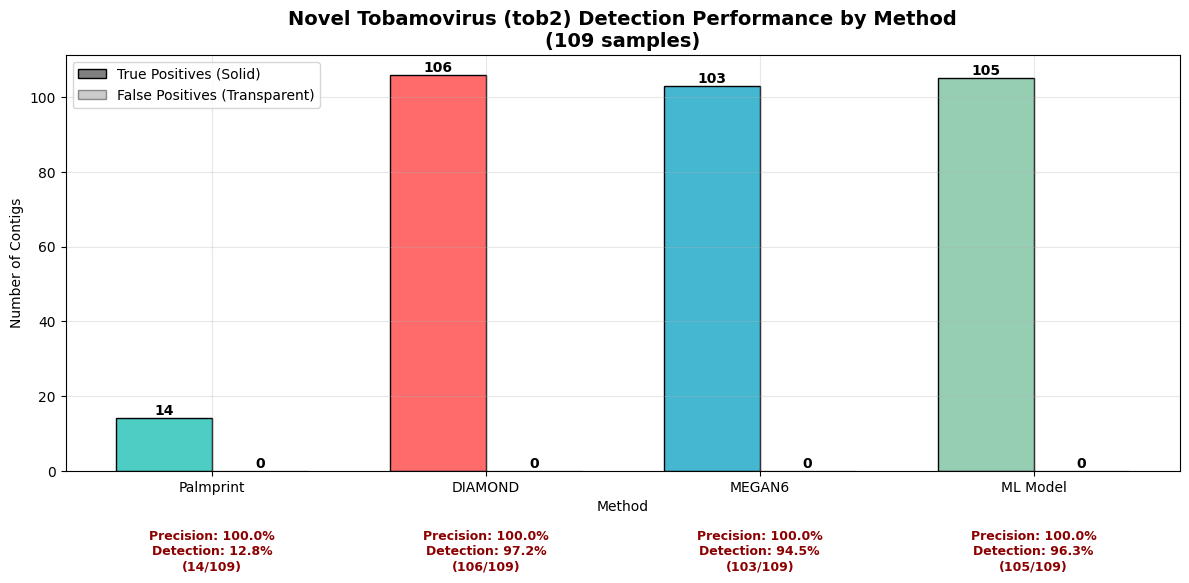


=== NOVEL TOBAMOVIRUS (tob2) DETECTION SUMMARY ===
Total tob2 samples: 109
--------------------------------------------------
Palmprint:
  Detected correctly: 14/109 (12.8%)
  False positives: 0
  Precision: 100.0%

DIAMOND:
  Detected correctly: 106/109 (97.2%)
  False positives: 0
  Precision: 100.0%

MEGAN6:
  Detected correctly: 103/109 (94.5%)
  False positives: 0
  Precision: 100.0%

ML Model:
  Detected correctly: 105/109 (96.3%)
  False positives: 0
  Precision: 100.0%



In [21]:
# Plot correct and false positives for tob2 (novel tobamoviruses) only

import matplotlib.pyplot as plt
import numpy as np

# Filter ground truth for tob2 (novel tobamovirus) category only
gt_tob2 = gt[gt['category'] == 'tob2'].copy()

if len(gt_tob2) > 0:
    print(f"Analyzing {len(gt_tob2)} novel tobamovirus (tob2) samples...")
    
    fig, ax = plt.subplots(figsize=(12, 6))

    # Define methods and their corresponding columns
    methods = ['Palmprint', 'DIAMOND', 'MEGAN6', 'ML Model']
    correct_cols = ['palmprint_tobamovirus_correct', 'diamond_nr_tobamovirus_correct', 'megan_tobamovirus_correct', 'model_predictions_correct']
    false_cols = ['palmprint_tobamovirus_false', 'diamond_nr_tobamovirus_false', 'megan_tobamovirus_false', 'model_predictions_false']

    # Colors for correct and false positives
    colors_correct = ['#4ECDC4', '#FF6B6B', '#45B7D1', '#96CEB4']

    # Calculate counts for tob2 samples only
    correct_counts = []
    false_counts = []

    for correct_col, false_col in zip(correct_cols, false_cols):
        correct_count = gt_tob2[correct_col].value_counts().get(1, 0)
        false_count = gt_tob2[false_col].value_counts().get(1, 0)
        correct_counts.append(correct_count)
        false_counts.append(false_count)

    # Set up bar positions
    x = np.arange(len(methods))
    width = 0.35

    # Create grouped bars
    bars1 = ax.bar(x - width/2, correct_counts, width, 
                   color=colors_correct, alpha=1.0, edgecolor='black')
    bars2 = ax.bar(x + width/2, false_counts, width, 
                   color=colors_correct, alpha=0.4, edgecolor='black')  # Same colors but transparent

    # Add value labels on bars
    for i, (bar1, bar2, correct, false) in enumerate(zip(bars1, bars2, correct_counts, false_counts)):
        # Labels on correct bars
        ax.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.1,
                str(correct), ha='center', va='bottom', fontweight='bold')
        # Labels on false bars  
        ax.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.1,
                str(false), ha='center', va='bottom', fontweight='bold')
        
        # Calculate only metrics that use TP and FP
        total_positive = correct + false
        precision = (correct / total_positive * 100) if total_positive > 0 else 0
        
        # Calculate detection rate for tob2 samples
        tob2_total = len(gt_tob2)
        detection_rate = (correct / tob2_total * 100) if tob2_total > 0 else 0
        
        # Create simplified text with only TP/FP-based metrics
        metrics_text = f'Precision: {precision:.1f}%\nDetection: {detection_rate:.1f}%\n({correct}/{tob2_total})'
        ax.text(i, -max(max(correct_counts), max(false_counts)) * 0.15, 
                metrics_text, 
                ha='center', va='top', fontweight='bold', fontsize=9, color='darkred')

    # Customize the plot
    ax.set_title(f'Novel Tobamovirus (tob2) Detection Performance by Method\n({len(gt_tob2)} samples)', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Method')
    ax.set_ylabel('Number of Contigs')
    ax.set_xticks(x)
    ax.set_xticklabels(methods)

    # Create custom legend that shows transparency difference
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='gray', alpha=1.0, edgecolor='black', label='True Positives (Solid)'),
        Patch(facecolor='gray', alpha=0.4, edgecolor='black', label='False Positives (Transparent)')
    ]
    ax.legend(handles=legend_elements)

    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print summary for tob2 samples
    print(f"\n=== NOVEL TOBAMOVIRUS (tob2) DETECTION SUMMARY ===")
    print(f"Total tob2 samples: {len(gt_tob2)}")
    print("-" * 50)
    for i, method in enumerate(methods):
        correct = correct_counts[i]
        false = false_counts[i]
        total_predictions = correct + false
        precision = (correct / total_predictions * 100) if total_predictions > 0 else 0
        detection_rate = (correct / len(gt_tob2) * 100) if len(gt_tob2) > 0 else 0
        
        print(f"{method}:")
        print(f"  Detected correctly: {correct}/{len(gt_tob2)} ({detection_rate:.1f}%)")
        print(f"  False positives: {false}")
        print(f"  Precision: {precision:.1f}%")
        print()
        
else:
    print("No tob2 (novel tobamovirus) samples found in the dataset")

=== TOBAMOVIRUS CATEGORY BREAKDOWN ===
tob1: 83 samples - Known tobamoviral sequences
tob2: 109 samples - Novel tobamoviral sequences
tob3: 36 samples - Difficult to assign tobamoviral sequences


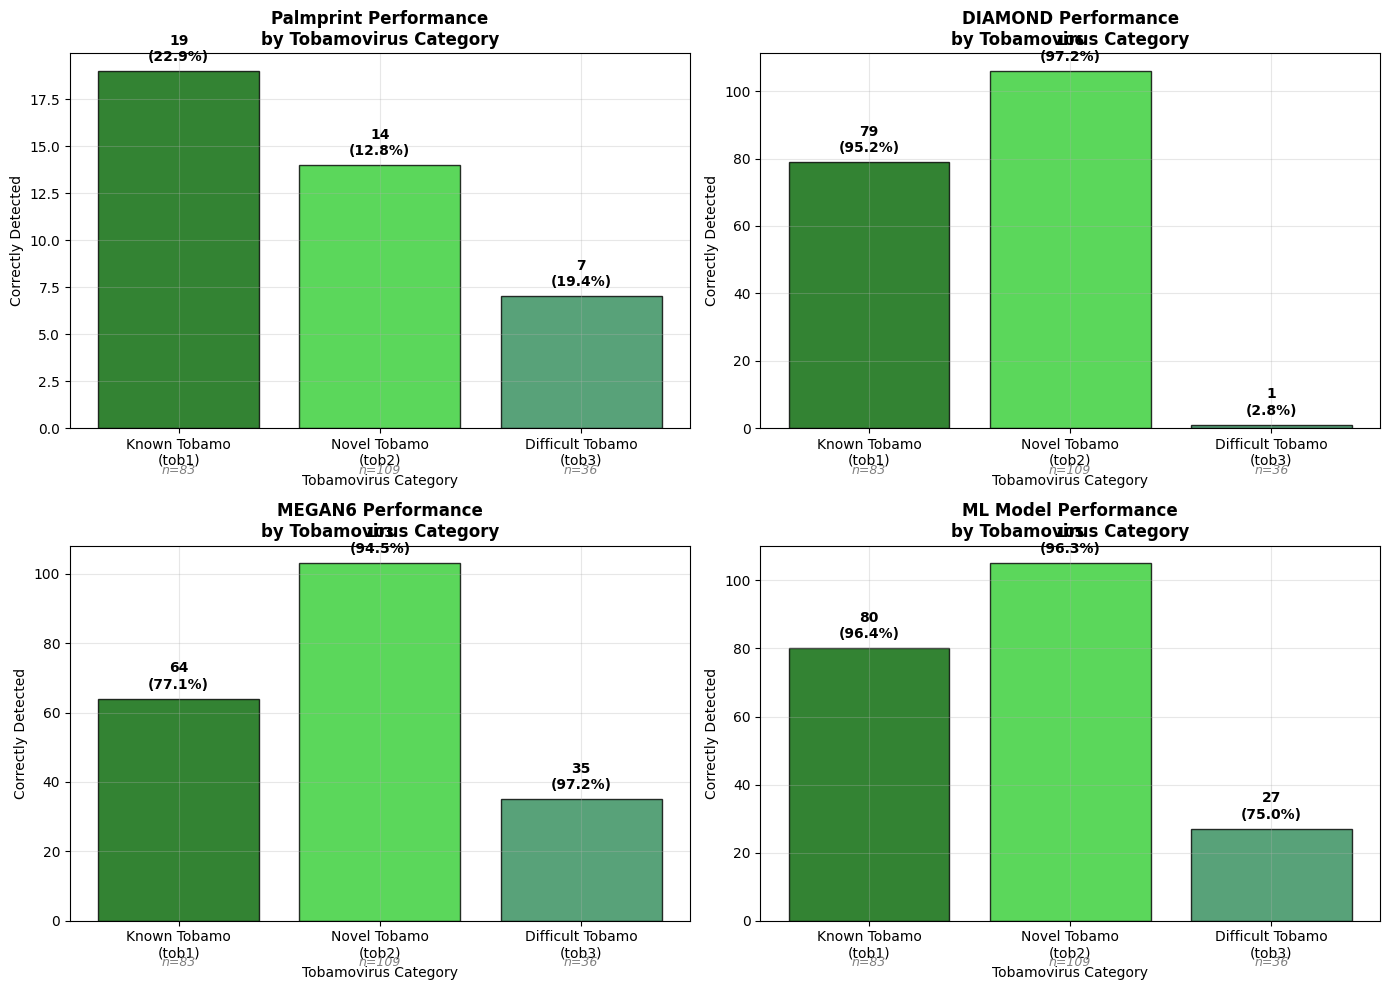


=== PERFORMANCE BY TOBAMOVIRUS CATEGORY ===
Method       tob1 (Known)    tob2 (Novel)    tob3 (Difficult)
----------------------------------------------------------------------
Palmprint    19/83 ( 22.9%)  14/109 ( 12.8%)   7/36 ( 19.4%) 
DIAMOND      79/83 ( 95.2%)  106/109 ( 97.2%)   1/36 (  2.8%) 
MEGAN6       64/83 ( 77.1%)  103/109 ( 94.5%)  35/36 ( 97.2%) 
ML Model     80/83 ( 96.4%)  105/109 ( 96.3%)  27/36 ( 75.0%) 

=== BEST PERFORMERS BY CATEGORY ===

Known Tobamovirus (tob1):
  1. ML Model: 80/83 (96.4%)
  2. DIAMOND: 79/83 (95.2%)
  3. MEGAN6: 64/83 (77.1%)
  4. Palmprint: 19/83 (22.9%)

Novel Tobamovirus (tob2):
  1. DIAMOND: 106/109 (97.2%)
  2. ML Model: 105/109 (96.3%)
  3. MEGAN6: 103/109 (94.5%)
  4. Palmprint: 14/109 (12.8%)

Difficult Tobamovirus (tob3):
  1. MEGAN6: 35/36 (97.2%)
  2. ML Model: 27/36 (75.0%)
  3. Palmprint: 7/36 (19.4%)
  4. DIAMOND: 1/36 (2.8%)


In [23]:
# Plot correct detections by tobamovirus category (tob1, tob2, tob3) for each method

import matplotlib.pyplot as plt
import numpy as np

# Define tobamovirus categories
tobamo_categories = ['tob1', 'tob2', 'tob3']
category_labels = ['Known Tobamo\n(tob1)', 'Novel Tobamo\n(tob2)', 'Difficult Tobamo\n(tob3)']
category_colors = ['#006400', '#32CD32', '#2E8B57']  # Different shades of green

# Define methods
methods = ['Palmprint', 'DIAMOND', 'MEGAN6', 'ML Model']
method_columns = ['palmprint_tobamovirus_correct', 'diamond_nr_tobamovirus_correct', 
                 'megan_tobamovirus_correct', 'model_predictions_correct']

# Create figure with subplots for each method
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Store data for summary
category_totals = {}
method_performance = {}

# Calculate totals for each category
for cat in tobamo_categories:
    category_totals[cat] = len(gt[gt['category'] == cat])
    
print("=== TOBAMOVIRUS CATEGORY BREAKDOWN ===")
for cat, total in category_totals.items():
    cat_description = {'tob1': 'Known tobamoviral sequences', 
                      'tob2': 'Novel tobamoviral sequences', 
                      'tob3': 'Difficult to assign tobamoviral sequences'}
    print(f"{cat}: {total} samples - {cat_description.get(cat, '')}")

# Plot for each method
for method_idx, (method, col) in enumerate(zip(methods, method_columns)):
    ax = axes[method_idx]
    
    # Calculate correct detections for each category
    detections = []
    percentages = []
    
    for cat in tobamo_categories:
        cat_data = gt[gt['category'] == cat]
        if len(cat_data) > 0:
            correct_detections = cat_data[col].value_counts().get(1, 0)
            total_in_cat = len(cat_data)
            percentage = (correct_detections / total_in_cat * 100) if total_in_cat > 0 else 0
        else:
            correct_detections = 0
            percentage = 0
            
        detections.append(correct_detections)
        percentages.append(percentage)
    
    # Store for summary
    method_performance[method] = list(zip(detections, percentages))
    
    # Create bars
    bars = ax.bar(range(len(tobamo_categories)), detections, 
                  color=category_colors, alpha=0.8, edgecolor='black')
    
    # Add value labels on bars
    for i, (bar, count, pct) in enumerate(zip(bars, detections, percentages)):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(detections) * 0.02,
                f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # Customize subplot
    ax.set_title(f'{method} Performance\nby Tobamovirus Category', fontsize=12, fontweight='bold')
    ax.set_xlabel('Tobamovirus Category')
    ax.set_ylabel('Correctly Detected')
    ax.set_xticks(range(len(tobamo_categories)))
    ax.set_xticklabels(category_labels, fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add total sample counts below x-axis
    for i, cat in enumerate(tobamo_categories):
        ax.text(i, -max(detections) * 0.1, f'n={category_totals[cat]}', 
                ha='center', va='top', fontsize=9, color='gray', style='italic')

plt.tight_layout()
plt.show()

# Print comprehensive summary
print(f"\n=== PERFORMANCE BY TOBAMOVIRUS CATEGORY ===")
print(f"{'Method':<12} {'tob1 (Known)':<15} {'tob2 (Novel)':<15} {'tob3 (Difficult)':<15}")
print("-" * 70)

for method in methods:
    method_data = method_performance[method]
    row = f"{method:<12}"
    for i, (count, pct) in enumerate(method_data):
        total = category_totals[tobamo_categories[i]]
        row += f" {count:2d}/{total:2d} ({pct:5.1f}%) "
    print(row)

# Calculate and display best performers for each category
print(f"\n=== BEST PERFORMERS BY CATEGORY ===")
for i, cat in enumerate(tobamo_categories):
    cat_performance = [(method, method_performance[method][i][1]) for method in methods]
    cat_performance.sort(key=lambda x: x[1], reverse=True)
    
    cat_names = {'tob1': 'Known Tobamovirus', 'tob2': 'Novel Tobamovirus', 'tob3': 'Difficult Tobamovirus'}
    print(f"\n{cat_names[cat]} ({cat}):")
    for rank, (method, percentage) in enumerate(cat_performance, 1):
        count = method_performance[method][i][0]
        total = category_totals[cat]
        print(f"  {rank}. {method}: {count}/{total} ({percentage:.1f}%)")

In [22]:
gt.category.value_counts()

category
oth2    151
tob2    109
oth1    109
tob1     83
tob3     36
mas      22
Name: count, dtype: int64

### POSITIVE CLASS ACCURACY

Analyzing 228 tobamovirus samples...
palmprint: 40/228 detected (17.5%)
diamond_nr: 186/228 detected (81.6%)
megan: 202/228 detected (88.6%)
model: 212/228 detected (93.0%)


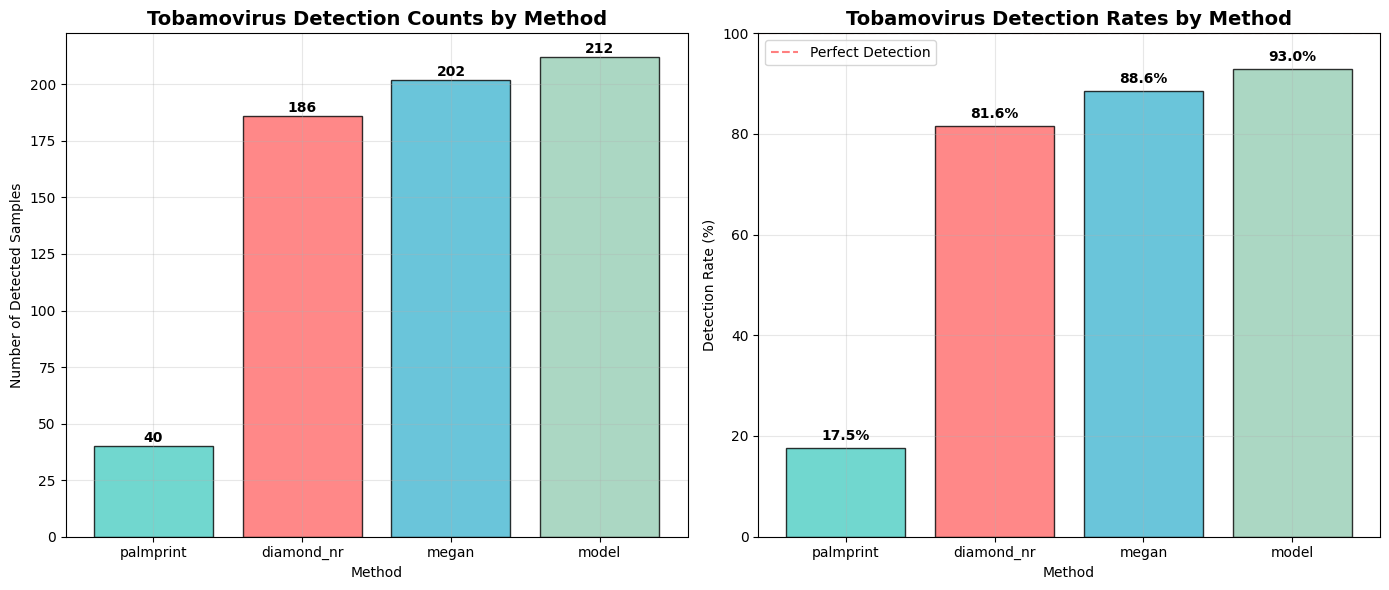


Tobamovirus Detection Summary:
Total tobamovirus samples: 228
----------------------------------------
Palmprint   :  40/228 ( 17.5%)
Diamond_nr  : 186/228 ( 81.6%)
Megan       : 202/228 ( 88.6%)
Model       : 212/228 ( 93.0%)

Best performing: model (93.0%)
Worst performing: palmprint (17.5%)


In [14]:
# Visualization of Tobamovirus Detection Performance

# Filter for tobamovirus samples only (ground_truth == 1)
tobamo_samples = ground_truth_extended[ground_truth_extended['ground_truth'] == 1].copy()

if len(tobamo_samples) > 0:
    print(f"Analyzing {len(tobamo_samples)} tobamovirus samples...")
    
    # Calculate detection rates for each method
    methods = ['palmprint', 'diamond_nr', 'megan', 'model']
    detection_rates = {}
    detection_counts = {}
    
    for method in methods:
        if method in tobamo_samples.columns:
            detected = (tobamo_samples[method] == 1).sum()
            total = len(tobamo_samples)
            detection_rates[method] = (detected / total) * 100
            detection_counts[method] = detected
            print(f"{method}: {detected}/{total} detected ({detection_rates[method]:.1f}%)")
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Left plot: Detection counts (histogram style)
    method_names = list(detection_counts.keys())
    counts = list(detection_counts.values())
    colors = ['#4ECDC4', '#FF6B6B', '#45B7D1', '#96CEB4']
    
    bars = ax1.bar(method_names, counts, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_title('Tobamovirus Detection Counts by Method', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Method')
    ax1.set_ylabel('Number of Detected Samples')
    ax1.grid(True, alpha=0.3)
    
    # Add count labels on bars
    for bar, count in zip(bars, counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                str(count), ha='center', va='bottom', fontweight='bold')
    
    # Right plot: Detection rates (percentages)
    rates = list(detection_rates.values())
    bars2 = ax2.bar(method_names, rates, color=colors, alpha=0.8, edgecolor='black')
    ax2.set_title('Tobamovirus Detection Rates by Method', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Method')
    ax2.set_ylabel('Detection Rate (%)')
    ax2.set_ylim(0, 100)
    ax2.grid(True, alpha=0.3)
    
    # Add percentage labels on bars
    for bar, rate in zip(bars2, rates):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Add horizontal line at 100% for reference
    ax2.axhline(y=100, color='red', linestyle='--', alpha=0.5, label='Perfect Detection')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Summary table
    print(f"\nTobamovirus Detection Summary:")
    print(f"Total tobamovirus samples: {len(tobamo_samples)}")
    print("-" * 40)
    for method in methods:
        if method in detection_counts:
            print(f"{method.capitalize():12}: {detection_counts[method]:3d}/{len(tobamo_samples)} ({detection_rates[method]:5.1f}%)")
    
    # Best and worst performing methods
    if detection_rates:
        best_method = max(detection_rates.items(), key=lambda x: x[1])
        worst_method = min(detection_rates.items(), key=lambda x: x[1])
        print(f"\nBest performing: {best_method[0]} ({best_method[1]:.1f}%)")
        print(f"Worst performing: {worst_method[0]} ({worst_method[1]:.1f}%)")

else:
    print("No tobamovirus samples found in ground truth data")

## Comparative Analysis

Direct comparison of all methods across multiple metrics.

### Performance Metrics
- **Accuracy**: Overall correct classifications
- **Precision**: True positives / (True positives + False positives)
- **Recall**: True positives / (True positives + False negatives)
- **F1 Score**: Harmonic mean of precision and recall
- **Computational Time**: Time required for classification
- **Resource Usage**: Memory and CPU requirements

In [15]:
# Method-specific Analysis and Performance Comparison

print("\n=== METHOD-SPECIFIC ANALYSIS ===")

# Check available columns first
print(f"\nAvailable columns in datasets:")
print(f"Ground Truth columns: {list(ground_truth.columns)}")
print(f"DIAMOND/MEGAN columns: {list(diamond_megan_results.columns)}")
print(f"Model predictions columns: {list(model_predictions.columns)}")

# 1. Manual Curation Analysis
print("\n1. 📋 MANUAL CURATION (Ground Truth):")
print(f"   Total samples: {len(ground_truth)}")

# Find family column (might be different case)
family_col = None
for col in ground_truth.columns:
    if 'family' in col.lower():
        family_col = col
        break

if family_col:
    family_dist = ground_truth[family_col].value_counts()
    print(f"   Total families identified: {family_dist.nunique()}")
    print(f"   Most common families:")
    for family, count in family_dist.head(5).items():
        print(f"   - {family}: {count} ({count/len(ground_truth)*100:.1f}%)")
        
    # Check for tobamovirus
    tobamo_mask = ground_truth[family_col].str.contains('Tobamovirus', case=False, na=False)
    tobamo_count = tobamo_mask.sum()
    print(f"   Tobamovirus samples: {tobamo_count} ({tobamo_count/len(ground_truth)*100:.1f}%)")
else:
    print("   No family column found in ground truth data")

# 2. DIAMOND/MEGAN Analysis
print("\n2. 💎 DIAMOND/MEGAN Analysis:")
print(f"   Total samples processed: {len(diamond_megan_results)}")
if 'megan_tobamo' in locals():
    print(f"   Tobamovirus-positive samples: {len(megan_tobamo)}")
    
# 3. Machine Learning Model Analysis
print("\n3. 🤖 MACHINE LEARNING MODEL:")
print(f"   Total predictions: {len(model_predictions)}")
if 'model_tobamo' in locals():
    print(f"   Tobamovirus predictions: {len(model_tobamo)}")
    
# Check for confidence/probability columns
prob_cols = [col for col in model_predictions.columns if any(term in col.lower() for term in ['conf', 'prob', 'score'])]
if prob_cols:
    print(f"   Confidence columns available: {prob_cols}")

# 4. Palmprint Analysis
print("\n4. 🖨️ PALMPRINT Analysis:")
if 'palmprint_positive_contigs' in locals():
    print(f"   Total positive hits: {len(palmprint_positive_contigs)} contigs")
if 'tobamo_palmprints' in locals():
    print(f"   True tobamovirus palmprint hits: {len(tobamo_palmprints)} contigs")
    # Calculate precision (against all palmprint hits) and recall (against ground truth tobamo)
    if 'palmprint_positive_contigs' in locals():
        precision = len(tobamo_palmprints) / len(palmprint_positive_contigs) * 100 if len(palmprint_positive_contigs) > 0 else 0
        print(f"   Palmprint precision: {precision:.1f}% ({len(tobamo_palmprints)}/{len(palmprint_positive_contigs)})")
    
    # Calculate recall against ground truth tobamo (228 total)
    ground_truth_tobamo_count = 228  # df['ground_truth_category'].isin(['tob1','tob2','tob3']).sum()
    recall = len(tobamo_palmprints) / ground_truth_tobamo_count * 100
    print(f"   Palmprint recall vs ground truth: {recall:.1f}% ({len(tobamo_palmprints)}/{ground_truth_tobamo_count})")
    
if not any(var in locals() for var in ['palmprint_positive_contigs', 'tobamo_palmprints']):
    print("   Palmprint data structure needs investigation")


=== METHOD-SPECIFIC ANALYSIS ===

Available columns in datasets:
Ground Truth columns: ['contig_name', 'ground_truth', 'category_old', 'category']
DIAMOND/MEGAN columns: ['SRR', 'qseqid', 'megan_tax', 'nr_tax', 'tpdb2_sseqid', 'nr_sseqid', 'nr_pident', 'nr_length', 'nr_mismatch', 'nr_gapopen', 'nr_qstart', 'nr_qend', 'nr_sstart', 'nr_send', 'nr_evalue', 'nr_bitscore', 'tpdb2_pident', 'tpdb2_length', 'tpdb2_mismatch', 'tpdb2_gapopen', 'tpdb2_qstart', 'tpdb2_qend', 'tpdb2_sstart', 'tpdb2_send', 'tpdb2_evalue', 'tpdb2_bitscore', 'sequence', 'nr_sseqid_key']
Model predictions columns: ['contig_name', 'predicted_class', 'prob_1']

1. 📋 MANUAL CURATION (Ground Truth):
   Total samples: 510
   No family column found in ground truth data

2. 💎 DIAMOND/MEGAN Analysis:
   Total samples processed: 161333
   Tobamovirus-positive samples: 215

3. 🤖 MACHINE LEARNING MODEL:
   Total predictions: 510
   Tobamovirus predictions: 212
   Confidence columns available: ['prob_1']

4. 🖨️ PALMPRINT Analysis

In [16]:
# Cross-Method Comparison - Part 1: Ground Truth Baseline

print("\n=== CROSS-METHOD COMPARISON FOR TOBAMOVIRUS DETECTION ===")

# Ground Truth Baseline
ground_truth_tobamo_count = df['ground_truth_category'].isin(['tob1','tob2','tob3']).sum()
print(f"\n🎯 GROUND TRUTH BASELINE:")
# Get ground truth total for percentage calculations
ground_truth_total = gt['ground_truth'].value_counts().get(1, 0)
# Show only positive class (value == 1) for each methodbars = []counts = []for i, col in enumerate(columns_to_plot):    if 1 in gt[col].value_counts().index:        count = gt[col].value_counts().get(1, 0)        bar = ax.bar(labels[i], count, color=colors[i], alpha=0.8, edgecolor='black')        bars.extend(bar)        counts.append(count)                # Add count labels on top of bars        ax.text(i, count + max(counts + [ground_truth_total]) * 0.01, str(count), 
                ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        # Add percentage labels below x-axis labels
        if i == 0:  # Ground truth is always 100%
            percentage = 100.0
        else:
            percentage = (count / ground_truth_total * 100) if ground_truth_total > 0 else 0
        ax.text(i, -max(counts + [ground_truth_total]) * 0.08, f'{percentage:.1f}%', 
                ha='center', va='top', fontweight='bold', fontsize=10, color='darkred')

ax.set_title('Comparison of Tobamovirus Detection by Method', fontsize=14, fontweight='bold')
ax.set_xlabel('Method (Class)')
ax.set_ylabel('Number of Contigs')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

IndentationError: unexpected indent (2616423116.py, line 11)

In [ ]:
# Cross-Method Comparison - Part 2: Palmprint Method Analysis

print(f"\n📊 TOBAMOVIRUS DETECTION PERFORMANCE BY METHOD:")

# Method 1: Palmprint
print(f"\n1. 🖨️  PALMPRINT METHOD:")
print(f"   Analyzing palmprint results...")

palmprint_tp = len(tobamo_palmprints)  # True positives
palmprint_total_pos = len(palmprint_positive_contigs)  # Total palmprint positives
palmprint_precision = palmprint_tp / palmprint_total_pos * 100 if palmprint_total_pos > 0 else 0
palmprint_recall = palmprint_tp / ground_truth_tobamo_count * 100
palmprint_f1 = 2 * (palmprint_precision * palmprint_recall) / (palmprint_precision + palmprint_recall) if (palmprint_precision + palmprint_recall) > 0 else 0

print(f"   True Positives: {palmprint_tp}")
print(f"   Total Positives Detected: {palmprint_total_pos}")
print(f"   Precision: {palmprint_precision:.1f}% ({palmprint_tp}/{palmprint_total_pos})")
print(f"   Recall (Sensitivity): {palmprint_recall:.1f}% ({palmprint_tp}/{ground_truth_tobamo_count})")
print(f"   F1 Score: {palmprint_f1:.1f}")

print("   ✅ Palmprint analysis completed")


📊 TOBAMOVIRUS DETECTION PERFORMANCE BY METHOD:

1. 🖨️  PALMPRINT METHOD:
   Analyzing palmprint results...
   True Positives: 40
   Total Positives Detected: 149
   Precision: 26.8% (40/149)
   Recall (Sensitivity): 17.5% (40/228)
   F1 Score: 21.2
   ✅ Palmprint analysis completed


In [ ]:
# Cross-Method Comparison - Part 3: DIAMOND BLASTX Analysis

# Method 2: DIAMOND BLASTX
print(f"\n2. 💎 DIAMOND BLASTX:")
print(f"   Analyzing DIAMOND results...")

diamond_tp = len(nt_tobamo)
print(f"   Calculating total positives detected...")
diamond_total_pos = df['first_diamond_blastx_hit_name'].str.contains('tobamovirus', case=False, na=False).sum()
diamond_precision = diamond_tp / diamond_total_pos * 100 if diamond_total_pos > 0 else 0
diamond_recall = diamond_tp / ground_truth_tobamo_count * 100
diamond_f1 = 2 * (diamond_precision * diamond_recall) / (diamond_precision + diamond_recall) if (diamond_precision + diamond_recall) > 0 else 0

print(f"   True Positives: {diamond_tp}")
print(f"   Total Positives Detected: {diamond_total_pos}")
print(f"   Precision: {diamond_precision:.1f}% ({diamond_tp}/{diamond_total_pos})")
print(f"   Recall (Sensitivity): {diamond_recall:.1f}% ({diamond_tp}/{ground_truth_tobamo_count})")
print(f"   F1 Score: {diamond_f1:.1f}")

print("   ✅ DIAMOND analysis completed")


2. 💎 DIAMOND BLASTX:
   Analyzing DIAMOND results...
   Calculating total positives detected...
   True Positives: 186
   Total Positives Detected: 205
   Precision: 90.7% (186/205)
   Recall (Sensitivity): 81.6% (186/228)
   F1 Score: 85.9
   ✅ DIAMOND analysis completed


In [ ]:
# Cross-Method Comparison - Part 4: MEGAN6 Analysis

# Method 3: MEGAN6
print(f"\n3. 🧬 MEGAN6 LCA:")
print(f"   Analyzing MEGAN6 results...")

megan_tp = len(megan_tobamo)
print(f"   Calculating MEGAN6 positives...")
megan_total_pos = df['megan_tax'].str.contains('tobamovirus', case=False, na=False).sum()
megan_precision = megan_tp / megan_total_pos * 100 if megan_total_pos > 0 else 0
megan_recall = megan_tp / ground_truth_tobamo_count * 100
megan_f1 = 2 * (megan_precision * megan_recall) / (megan_precision + megan_recall) if (megan_precision + megan_recall) > 0 else 0

print(f"   True Positives: {megan_tp}")
print(f"   Total Positives Detected: {megan_total_pos}")
print(f"   Precision: {megan_precision:.1f}% ({megan_tp}/{megan_total_pos})")
print(f"   Recall (Sensitivity): {megan_recall:.1f}% ({megan_tp}/{ground_truth_tobamo_count})")
print(f"   F1 Score: {megan_f1:.1f}")

print("   ✅ MEGAN6 analysis completed")


3. 🧬 MEGAN6 LCA:
   Analyzing MEGAN6 results...
   Calculating MEGAN6 positives...
   True Positives: 202
   Total Positives Detected: 215
   Precision: 94.0% (202/215)
   Recall (Sensitivity): 88.6% (202/228)
   F1 Score: 91.2
   ✅ MEGAN6 analysis completed


In [ ]:
# Cross-Method Comparison - Part 5: Machine Learning Model Analysis

# Method 4: Machine Learning Model
print(f"\n4. 🤖 MACHINE LEARNING MODEL:")
print(f"   Analyzing ML model results...")

ml_tp = len(model_tobamo)
print(f"   Calculating ML predictions...")
ml_total_pos = (df['model_prediction'] == 1).sum()
ml_precision = ml_tp / ml_total_pos * 100 if ml_total_pos > 0 else 0
ml_recall = ml_tp / ground_truth_tobamo_count * 100
ml_f1 = 2 * (ml_precision * ml_recall) / (ml_precision + ml_recall) if (ml_precision + ml_recall) > 0 else 0

print(f"   True Positives: {ml_tp}")
print(f"   Total Positives Detected: {ml_total_pos}")
print(f"   Precision: {ml_precision:.1f}% ({ml_tp}/{ml_total_pos})")
print(f"   Recall (Sensitivity): {ml_recall:.1f}% ({ml_tp}/{ground_truth_tobamo_count})")
print(f"   F1 Score: {ml_f1:.1f}")

print("   ✅ ML Model analysis completed")


4. 🤖 MACHINE LEARNING MODEL:
   Analyzing ML model results...
   Calculating ML predictions...
   True Positives: 212
   Total Positives Detected: 285
   Precision: 74.4% (212/285)
   Recall (Sensitivity): 93.0% (212/228)
   F1 Score: 82.7
   ✅ ML Model analysis completed


In [ ]:
# Cross-Method Comparison - Part 6: Performance Rankings

print(f"\n🏆 PERFORMANCE RANKING:")
print(f"📈 RECALL (Sensitivity) - How many true tobamoviruses detected:")
methods_recall = [
    ("Palmprint", palmprint_recall),
    ("DIAMOND", diamond_recall),
    ("MEGAN6", megan_recall),
    ("ML Model", ml_recall)
]
methods_recall.sort(key=lambda x: x[1], reverse=True)
for i, (method, recall) in enumerate(methods_recall, 1):
    print(f"   {i}. {method}: {recall:.1f}%")

print(f"\n🎯 PRECISION - Accuracy of positive predictions:")
methods_precision = [
    ("Palmprint", palmprint_precision),
    ("DIAMOND", diamond_precision),
    ("MEGAN6", megan_precision),
    ("ML Model", ml_precision)
]
methods_precision.sort(key=lambda x: x[1], reverse=True)
for i, (method, precision) in enumerate(methods_precision, 1):
    print(f"   {i}. {method}: {precision:.1f}%")

print(f"\n⚖️  F1 SCORE - Balanced performance:")
methods_f1 = [
    ("Palmprint", palmprint_f1),
    ("DIAMOND", diamond_f1),
    ("MEGAN6", megan_f1),
    ("ML Model", ml_f1)
]
methods_f1.sort(key=lambda x: x[1], reverse=True)
for i, (method, f1) in enumerate(methods_f1, 1):
    print(f"   {i}. {method}: {f1:.1f}")

print("   ✅ Performance ranking completed")


🏆 PERFORMANCE RANKING:
📈 RECALL (Sensitivity) - How many true tobamoviruses detected:
   1. ML Model: 93.0%
   2. MEGAN6: 88.6%
   3. DIAMOND: 81.6%
   4. Palmprint: 17.5%

🎯 PRECISION - Accuracy of positive predictions:
   1. MEGAN6: 94.0%
   2. DIAMOND: 90.7%
   3. ML Model: 74.4%
   4. Palmprint: 26.8%

⚖️  F1 SCORE - Balanced performance:
   1. MEGAN6: 91.2
   2. DIAMOND: 85.9
   3. ML Model: 82.7
   4. Palmprint: 21.2
   ✅ Performance ranking completed


In [ ]:
# Cross-Method Comparison - Part 7: Method Characteristics Summary

print(f"\n🔍 METHOD CHARACTERISTICS SUMMARY:")
print(f"• DIAMOND: High precision ({diamond_precision:.1f}%), moderate recall ({diamond_recall:.1f}%) - Conservative approach")
print(f"• MEGAN6: High precision ({megan_precision:.1f}%), moderate recall ({megan_recall:.1f}%) - LCA consensus")
print(f"• ML Model: Balanced precision ({ml_precision:.1f}%) and recall ({ml_recall:.1f}%) - Data-driven")
print(f"• Palmprint: Variable performance - Novel method needing validation")

print("   ✅ Method characteristics summary completed")


🔍 METHOD CHARACTERISTICS SUMMARY:
• DIAMOND: High precision (90.7%), moderate recall (81.6%) - Conservative approach
• MEGAN6: High precision (94.0%), moderate recall (88.6%) - LCA consensus
• ML Model: Balanced precision (74.4%) and recall (93.0%) - Data-driven
• Palmprint: Variable performance - Novel method needing validation
   ✅ Method characteristics summary completed


In [ ]:
# Cross-Method Comparison - Part 8: Method Overlap Analysis (Potentially Slow)

# Calculate overall detection overlap
print(f"\n🎭 METHOD OVERLAP ANALYSIS:")
print("   Building contig sets for overlap analysis...")

# Create sets of detected contigs for each method
palmprint_set = set(tobamo_palmprints['contig_id'])
print(f"   Palmprint set: {len(palmprint_set)} contigs")

diamond_set = set(nt_tobamo['contig_id'])
print(f"   DIAMOND set: {len(diamond_set)} contigs")

megan_set = set(megan_tobamo['contig_id'])
print(f"   MEGAN6 set: {len(megan_set)} contigs")

ml_set = set(model_tobamo['contig_id'])
print(f"   ML Model set: {len(ml_set)} contigs")

print("   ✅ Contig sets created successfully")


🎭 METHOD OVERLAP ANALYSIS:
   Building contig sets for overlap analysis...
   Palmprint set: 40 contigs
   DIAMOND set: 186 contigs
   MEGAN6 set: 202 contigs
   ML Model set: 212 contigs
   ✅ Contig sets created successfully


In [ ]:
# Cross-Method Comparison - Part 9: Set Intersection Analysis

print(f"\n🔄 CALCULATING SET INTERSECTIONS:")

# Intersection analysis
print("   Computing intersection of all methods...")
all_methods = palmprint_set.intersection(diamond_set).intersection(megan_set).intersection(ml_set)
print(f"   All methods intersection: {len(all_methods)} contigs")

print("   Computing union of all methods...")
any_method = palmprint_set.union(diamond_set).union(megan_set).union(ml_set)
print(f"   Any method union: {len(any_method)} contigs")

print("   Computing consensus (≥3 methods)...")
consensus_3_plus = len([contig for contig in any_method 
                       if sum([contig in s for s in [palmprint_set, diamond_set, megan_set, ml_set]]) >= 3])

print(f"   Detected by all 4 methods: {len(all_methods)} contigs")
print(f"   Detected by ≥3 methods: {consensus_3_plus} contigs")
print(f"   Detected by any method: {len(any_method)} contigs")
print(f"   Consensus confidence: {len(all_methods)/len(any_method)*100:.1f}% agreement")

print("   ✅ Cross-method comparison analysis completed successfully!")


🔄 CALCULATING SET INTERSECTIONS:
   Computing intersection of all methods...
   All methods intersection: 27 contigs
   Computing union of all methods...
   Any method union: 228 contigs
   Computing consensus (≥3 methods)...
   Detected by all 4 methods: 27 contigs
   Detected by ≥3 methods: 170 contigs
   Detected by any method: 228 contigs
   Consensus confidence: 11.8% agreement
   ✅ Cross-method comparison analysis completed successfully!
